In [2]:
import pandas as pd
import numpy as np
import lifelines
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from patsy import dmatrix

In [3]:
df_train = pd.read_csv('df_train_cph1.csv')
df_test = pd.read_csv('df_test_cph1.csv')

In [4]:
# CPH2 (model perforamnces and POVERTY graph)

In [5]:
df_train_cph2 = df_train.copy()
df_test_cph2 = df_test.copy()

In [6]:
# BMICALC

In [7]:
# top and bottom code BMICALC
df_train_cph2['BMICALC'] = df_train_cph2['BMICALC'].clip(upper=50, lower=16)
df_test_cph2['BMICALC'] = df_test_cph2['BMICALC'].clip(upper=50, lower=16)

In [8]:
# BMI with splines (for different spline confidurations change d and df values in formula)

formula="bs(BMICALC, degree=2, df=3) +" + " + ".join(df_train_cph2.columns.difference(['TIMETOEVENT', 'MORTSTAT', 'BMICALC']))

cph = CoxPHFitter()
cph.fit(df_train_cph2, duration_col='TIMETOEVENT', event_col='MORTSTAT', formula=formula)

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 82720 total observations, 78101 right-censored observations>
             duration col = 'TIMETOEVENT'
                event col = 'MORTSTAT'
      baseline estimation = breslow
   number of observations = 82720
number of events observed = 4619
   partial log-likelihood = -45601.44
         time fit was run = 2025-03-10 00:15:26 UTC

---
                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                       
bs(BMICALC, degree=2, df=3)[1] -1.12      0.33      0.14           -1.39           -0.85                0.25                0.43
bs(BMICALC, degree=2, df=3)[2] -1.33      0.26      0.11           -1.54           -1.12                0.21                0.33
bs(BMICALC, degree=2, df=3)[3] -0.65      0.52      0.21           -1.07           -0.24                0.34                0.79
AEFFORT                         0.08      1.08      0.02            0.04            0.12                1.04                1.12
AFEELINT1MO                    -0.06      0.95      0.02           -0.09           -0.02                0.91                0.98
AGE                             0.07      1.07      0.00            0.07            0.07                1.07                1.08
ALC5UPYR                        0.00      1.00      0.00            0.00            0.00                1.00                1.00
ALCAMT                          0.01      1.01      0.01           -0.01            0.03                0.99                1.03
ALCDAYSYR                      -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
ALCSTAT1_2                      0.01      1.01      0.04           -0.07            0.09                0.93                1.10
ALCSTAT1_3                     -0.16      0.85      0.05           -0.25           -0.06                0.78                0.94
ARTHGLUPEV                     -0.02      0.98      0.03           -0.08            0.04                0.92                1.04
AWORTHLESS                      0.01      1.01      0.02           -0.04            0.05                0.96                1.05
BLIND                           0.62      1.86      0.11            0.41            0.83                1.50                2.29
CANCEREV                        0.29      1.34      0.03            0.23            0.36                1.25                1.44
CHEARTDIEV                      0.18      1.20      0.04            0.09            0.27                1.10                1.31
CIGSDAY                         0.01      1.01      0.00           -0.00            0.01                1.00                1.01
CPOXEV                         -0.09      0.91      0.04           -0.16           -0.02                0.85                0.98
DIABETICEV                      0.18      1.20      0.04            0.11            0.26                1.12                1.29
EDUCREC1                        0.01      1.01      0.01           -0.01            0.02                0.99                1.02
EMPHYSEMEV                      0.30      1.34      0.06            0.18            0.41                1.20                1.50
FAMSIZE                         0.00      1.00      0.02           -0.03            0.03                0.97                1.04
FSRAWSCORE                      0.00      1.00      0.01           -0.02            0.02                0.98                1.02
HEARTATTEV                      0.13      1.14      0.05            0.03            0.23                1.03                1.25
HEARTCONEV                      0.22      1.25      0.04            0.15            0.30                1.16                1.35
HIMCAIDE                        0.11      1.12      0.05            0.02            0.21                1.02                1.23
HIMCAREE    

In [9]:
print(f'APLL_is: {cph.score(df_train_cph2, scoring_method="log_likelihood"):.4f}')
print(f'APLL_os: {cph.score(df_test_cph2, scoring_method="log_likelihood"):.4f}')
print(f'APLL_is: {cph.score(df_train_cph2, scoring_method="concordance_index"):.4f}')
print(f'APLL_os: {cph.score(df_test_cph2, scoring_method="concordance_index"):.4f}')

APLL_is: -0.5513
APLL_os: -0.4617
APLL_is: 0.8841
APLL_os: 0.8876


In [10]:
# predict the survival function for each individual
survival_probs_16_train = cph.predict_survival_function(df_train_cph2)
survival_probs_16_test = cph.predict_survival_function(df_test_cph2)

# extract 3y survival probabilities
survival_prob_3y_train = survival_probs_16_train.iloc[3] 
survival_prob_3y_test = survival_probs_16_test.iloc[3] 

# get 3-year event status based on TIMETOEVENT and MORTSTAT
status_3y_train = np.where((df_train_cph2["MORTSTAT"] == 1) & (df_train_cph2["TIMETOEVENT"] <= 3), 0, 1)
status_3y_test = np.where((df_test_cph2["MORTSTAT"] == 1) & (df_test_cph2["TIMETOEVENT"] <= 3), 0, 1)

print(f'log-loss is: {log_loss(status_3y_train, survival_prob_3y_train):.4f}')
print(f'log-loss os: {log_loss(status_3y_test, survival_prob_3y_test):.4f}')
print(f'BS is: {brier_score_loss(status_3y_train, survival_prob_3y_train):.4f}')
print(f'BS os: {brier_score_loss(status_3y_test, survival_prob_3y_test):.4f}')

log-loss is: 0.1126
log-loss os: 0.1110
BS is: 0.0296
BS os: 0.0295


In [11]:
# HRSLEEP

In [12]:
# top and bottom code BMICALC
df_train_cph2['HRSLEEP'] = df_train_cph2['HRSLEEP'].clip(upper=15, lower=2)
df_test_cph2['HRSLEEP'] = df_test_cph2['HRSLEEP'].clip(upper=15, lower=2)

In [13]:
# HRLSEEP with splines (for different spline confidurations change d and df values in formula)

formula="bs(BMICALC, degree=2, df=3) + bs(HRSLEEP, degree=1, df=2) +" + " + ".join(df_train_cph2.columns.difference(['TIMETOEVENT', 'MORTSTAT', 'HRSLEEP', 'BMICALC']))

cph = CoxPHFitter()
cph.fit(df_train_cph2, duration_col='TIMETOEVENT', event_col='MORTSTAT', formula=formula)

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 82720 total observations, 78101 right-censored observations>
             duration col = 'TIMETOEVENT'
                event col = 'MORTSTAT'
      baseline estimation = breslow
   number of observations = 82720
number of events observed = 4619
   partial log-likelihood = -45577.62
         time fit was run = 2025-03-10 00:15:30 UTC

---
                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                       
bs(BMICALC, degree=2, df=3)[1] -1.13      0.32      0.14           -1.40           -0.85                0.25                0.43
bs(BMICALC, degree=2, df=3)[2] -1.33      0.26      0.11           -1.54           -1.12                0.21                0.33
bs(BMICALC, degree=2, df=3)[3] -0.67      0.51      0.21           -1.09           -0.25                0.34                0.78
bs(HRSLEEP, degree=1, df=2)[1] -0.32      0.73      0.10           -0.51           -0.13                0.60                0.88
bs(HRSLEEP, degree=1, df=2)[2]  0.71      2.03      0.10            0.50            0.91                1.65                2.50
AEFFORT                         0.07      1.08      0.02            0.04            0.11                1.04                1.12
AFEELINT1MO                    -0.05      0.95      0.02           -0.08           -0.01                0.92                0.99
AGE                             0.07      1.07      0.00            0.07            0.07                1.07                1.08
ALC5UPYR                        0.00      1.00      0.00            0.00            0.00                1.00                1.00
ALCAMT                          0.01      1.01      0.01           -0.01            0.03                0.99                1.03
ALCDAYSYR                      -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
ALCSTAT1_2                      0.01      1.01      0.04           -0.07            0.10                0.93                1.10
ALCSTAT1_3                     -0.15      0.86      0.05           -0.24           -0.06                0.78                0.94
ARTHGLUPEV                     -0.03      0.97      0.03           -0.09            0.04                0.91                1.04
AWORTHLESS                      0.00      1.00      0.02           -0.04            0.05                0.96                1.05
BLIND                           0.58      1.79      0.11            0.37            0.79                1.45                2.21
CANCEREV                        0.30      1.34      0.03            0.23            0.36                1.26                1.44
CHEARTDIEV                      0.18      1.19      0.04            0.09            0.26                1.09                1.30
CIGSDAY                         0.00      1.00      0.00           -0.00            0.01                1.00                1.01
CPOXEV                         -0.09      0.91      0.04           -0.17           -0.02                0.85                0.98
DIABETICEV                      0.18      1.20      0.04            0.11            0.25                1.12                1.29
EDUCREC1                        0.01      1.01      0.01           -0.01            0.02                1.00                1.02
EMPHYSEMEV                      0.29      1.34      0.06            0.18            0.40                1.20                1.49
FAMSIZE                        -0.00      1.00      0.02           -0.04            0.03                0.96                1.03
FSRAWSCORE                      0.00      1.00      0.01           -0.02            0.02                0.98                1.02
HEARTATTEV                      0.13      1.14      0.05            0.03            0.22                1.03                1.25
HEARTCONEV  

In [14]:
print(f'APLL_is: {cph.score(df_train_cph2, scoring_method="log_likelihood"):.4f}')
print(f'APLL_os: {cph.score(df_test_cph2, scoring_method="log_likelihood"):.4f}')
print(f'APLL_is: {cph.score(df_train_cph2, scoring_method="concordance_index"):.4f}')
print(f'APLL_os: {cph.score(df_test_cph2, scoring_method="concordance_index"):.4f}')

APLL_is: -0.5510
APLL_os: -0.4614
APLL_is: 0.8844
APLL_os: 0.8882


In [15]:
# predict the survival function for each individual
survival_probs_16_train = cph.predict_survival_function(df_train_cph2)
survival_probs_16_test = cph.predict_survival_function(df_test_cph2)

# extract 3y survival probabilities
survival_prob_3y_train = survival_probs_16_train.iloc[3] 
survival_prob_3y_test = survival_probs_16_test.iloc[3] 

# get 3-year event status based on TIMETOEVENT and MORTSTAT
status_3y_train = np.where((df_train_cph2["MORTSTAT"] == 1) & (df_train_cph2["TIMETOEVENT"] <= 3), 0, 1)
status_3y_test = np.where((df_test_cph2["MORTSTAT"] == 1) & (df_test_cph2["TIMETOEVENT"] <= 3), 0, 1)

print(f'log-loss is: {log_loss(status_3y_train, survival_prob_3y_train):.4f}')
print(f'log-loss os: {log_loss(status_3y_test, survival_prob_3y_test):.4f}')
print(f'BS is: {brier_score_loss(status_3y_train, survival_prob_3y_train):.4f}')
print(f'BS os: {brier_score_loss(status_3y_test, survival_prob_3y_test):.4f}')

log-loss is: 0.1125
log-loss os: 0.1107
BS is: 0.0295
BS os: 0.0294


In [16]:
# MOD10FWK

In [17]:
# top code
df_train_cph2['MOD10FWK'] = df_train_cph2['MOD10FWK'].clip(upper=8)
df_test_cph2['MOD10FWK'] = df_test_cph2['MOD10FWK'].clip(upper=8)

In [18]:
# VIG10FWK

In [19]:
# top code
df_train_cph2['VIG10FWK'] = df_train_cph2['VIG10FWK'].clip(upper=8)
df_test_cph2['VIG10FWK'] = df_test_cph2['VIG10FWK'].clip(upper=8)

In [20]:
# STRONGFWK

In [21]:
# top code
df_train_cph2['STRONGFWK'] = df_train_cph2['STRONGFWK'].clip(upper=8)
df_test_cph2['STRONGFWK'] = df_test_cph2['STRONGFWK'].clip(upper=8)

In [22]:
# STRONGFWK with splines (for different spline confidurations change d and df values in formula)

formula="bs(BMICALC, degree=2, df=3) + bs(HRSLEEP, degree=1, df=2) + bs(STRONGFWK, degree=2, df=2) +" + " + ".join(df_train_cph2.columns.difference(['TIMETOEVENT', 'MORTSTAT','BMICALC', 'HRSLEEP', 'STRONGFWK']))

cph = CoxPHFitter()
cph.fit(df_train_cph2, duration_col='TIMETOEVENT', event_col='MORTSTAT', formula=formula)

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 82720 total observations, 78101 right-censored observations>
             duration col = 'TIMETOEVENT'
                event col = 'MORTSTAT'
      baseline estimation = breslow
   number of observations = 82720
number of events observed = 4619
   partial log-likelihood = -45567.40
         time fit was run = 2025-03-10 00:15:34 UTC

---
                                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                         
bs(BMICALC, degree=2, df=3)[1]   -1.12      0.33      0.14           -1.39           -0.85                0.25                0.43
bs(BMICALC, degree=2, df=3)[2]   -1.34      0.26      0.11           -1.55           -1.13                0.21                0.32
bs(BMICALC, degree=2, df=3)[3]   -0.68      0.51      0.21           -1.09           -0.26                0.33                0.77
bs(HRSLEEP, degree=1, df=2)[1]   -0.31      0.73      0.10           -0.50           -0.12                0.60                0.89
bs(HRSLEEP, degree=1, df=2)[2]    0.70      2.02      0.11            0.50            0.91                1.65                2.48
bs(STRONGFWK, degree=2, df=2)[1] -0.33      0.72      0.14           -0.61           -0.06                0.55                0.94
bs(STRONGFWK, degree=2, df=2)[2]  0.08      1.08      0.10           -0.12            0.28                0.89                1.32
AEFFORT                           0.07      1.08      0.02            0.04            0.11                1.04                1.12
AFEELINT1MO                      -0.05      0.95      0.02           -0.08           -0.01                0.92                0.99
AGE                               0.07      1.07      0.00            0.07            0.07                1.07                1.08
ALC5UPYR                          0.00      1.00      0.00            0.00            0.00                1.00                1.00
ALCAMT                            0.01      1.01      0.01           -0.01            0.03                0.99                1.03
ALCDAYSYR                        -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
ALCSTAT1_2                        0.02      1.02      0.04           -0.07            0.10                0.93                1.10
ALCSTAT1_3                       -0.14      0.87      0.05           -0.24           -0.05                0.79                0.95
ARTHGLUPEV                       -0.03      0.97      0.03           -0.09            0.04                0.92                1.04
AWORTHLESS                        0.00      1.00      0.02           -0.04            0.05                0.96                1.05
BLIND                             0.58      1.79      0.11            0.37            0.79                1.44                2.21
CANCEREV                          0.30      1.34      0.03            0.23            0.36                1.26                1.44
CHEARTDIEV                        0.17      1.19      0.04            0.09            0.26                1.09                1.30
CIGSDAY                           0.00      1.00      0.00           -0.00            0.01                1.00                1.01
CPOXEV                           -0.09      0.91      0.04           -0.17           -0.02                0.85                0.98
DIABETICEV                        0.18      1.20      0.04            0.11            0.25                1.11                1.29
EDUCREC1                          0.01      1.01      0.01           -0.00            0.02                1.00                1.02
EMPHYSEMEV                        0.29      1.33      0.06            0.18            0.40                1.19                1.49
FAMSIZE                          -0.00      1.00      0.02           -0.04            0

In [23]:
print(f'APLL_is: {cph.score(df_train_cph2, scoring_method="log_likelihood"):.4f}')
print(f'APLL_os: {cph.score(df_test_cph2, scoring_method="log_likelihood"):.4f}')
print(f'APLL_is: {cph.score(df_train_cph2, scoring_method="concordance_index"):.4f}')
print(f'APLL_os: {cph.score(df_test_cph2, scoring_method="concordance_index"):.4f}')

APLL_is: -0.5509
APLL_os: -0.4612
APLL_is: 0.8847
APLL_os: 0.8887


In [24]:
# predict the survival function for each individual
survival_probs_16_train = cph.predict_survival_function(df_train_cph2)
survival_probs_16_test = cph.predict_survival_function(df_test_cph2)

# extract 3y survival probabilities
survival_prob_3y_train = survival_probs_16_train.iloc[3] 
survival_prob_3y_test = survival_probs_16_test.iloc[3] 

# get 3-year event status based on TIMETOEVENT and MORTSTAT
status_3y_train = np.where((df_train_cph2["MORTSTAT"] == 1) & (df_train_cph2["TIMETOEVENT"] <= 3), 0, 1)
status_3y_test = np.where((df_test_cph2["MORTSTAT"] == 1) & (df_test_cph2["TIMETOEVENT"] <= 3), 0, 1)

print(f'log-loss is: {log_loss(status_3y_train, survival_prob_3y_train):.4f}')
print(f'log-loss os: {log_loss(status_3y_test, survival_prob_3y_test):.4f}')
print(f'BS is: {brier_score_loss(status_3y_train, survival_prob_3y_train):.4f}')
print(f'BS os: {brier_score_loss(status_3y_test, survival_prob_3y_test):.4f}')

log-loss is: 0.1124
log-loss os: 0.1105
BS is: 0.0295
BS os: 0.0294


In [25]:
# MOD10DMIN

In [26]:
# top code
df_train_cph2['MOD10DMIN'] = df_train_cph2['MOD10DMIN'].clip(upper=121)
df_test_cph2['MOD10DMIN'] = df_test_cph2['MOD10DMIN'].clip(upper=121)

In [27]:
# VIG10DMIN

In [28]:
# top code
df_train_cph2['VIG10DMIN'] = df_train_cph2['VIG10DMIN'].clip(upper=121)
df_test_cph2['VIG10DMIN'] = df_test_cph2['VIG10DMIN'].clip(upper=121)

In [29]:
# ALCDAYSYR

In [30]:
# ALCDAYSYR with splines (for different spline confidurations change d and df values in formula)

formula="bs(BMICALC, degree=2, df=3) + bs(HRSLEEP, degree=1, df=2) + bs(STRONGFWK, degree=2, df=2) + bs(ALCDAYSYR, degree=1, df=2) +" + " + ".join(df_train_cph2.columns.difference(['TIMETOEVENT', 'MORTSTAT','BMICALC', 'HRSLEEP', 'STRONGFWK', 'ALCDAYSYR']))

cph = CoxPHFitter()
cph.fit(df_train_cph2, duration_col='TIMETOEVENT', event_col='MORTSTAT', formula=formula)

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 82720 total observations, 78101 right-censored observations>
             duration col = 'TIMETOEVENT'
                event col = 'MORTSTAT'
      baseline estimation = breslow
   number of observations = 82720
number of events observed = 4619
   partial log-likelihood = -45552.83
         time fit was run = 2025-03-10 00:15:38 UTC

---
                                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                         
bs(BMICALC, degree=2, df=3)[1]   -1.12      0.33      0.14           -1.39           -0.85                0.25                0.43
bs(BMICALC, degree=2, df=3)[2]   -1.34      0.26      0.11           -1.55           -1.13                0.21                0.32
bs(BMICALC, degree=2, df=3)[3]   -0.70      0.50      0.21           -1.11           -0.28                0.33                0.75
bs(HRSLEEP, degree=1, df=2)[1]   -0.30      0.74      0.10           -0.49           -0.11                0.61                0.89
bs(HRSLEEP, degree=1, df=2)[2]    0.70      2.01      0.11            0.49            0.91                1.64                2.47
bs(STRONGFWK, degree=2, df=2)[1] -0.27      0.76      0.14           -0.55            0.00                0.58                1.00
bs(STRONGFWK, degree=2, df=2)[2]  0.06      1.06      0.10           -0.14            0.25                0.87                1.29
bs(ALCDAYSYR, degree=1, df=2)[1] -0.20      0.82      0.08           -0.35           -0.05                0.71                0.95
bs(ALCDAYSYR, degree=1, df=2)[2] -0.30      0.74      0.08           -0.46           -0.14                0.63                0.87
AEFFORT                           0.07      1.08      0.02            0.03            0.11                1.04                1.12
AFEELINT1MO                      -0.05      0.95      0.02           -0.08           -0.01                0.92                0.99
AGE                               0.07      1.07      0.00            0.07            0.07                1.07                1.08
ALC5UPYR                          0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ALCAMT                            0.01      1.01      0.01           -0.01            0.03                0.99                1.03
ALCSTAT1_2                        0.02      1.02      0.04           -0.07            0.10                0.94                1.11
ALCSTAT1_3                       -0.01      0.99      0.07           -0.14            0.12                0.87                1.13
ARTHGLUPEV                       -0.03      0.97      0.03           -0.09            0.04                0.91                1.04
AWORTHLESS                        0.00      1.00      0.02           -0.04            0.05                0.96                1.05
BLIND                             0.58      1.78      0.11            0.36            0.79                1.44                2.20
CANCEREV                          0.30      1.35      0.03            0.23            0.37                1.26                1.44
CHEARTDIEV                        0.17      1.19      0.04            0.09            0.26                1.09                1.30
CIGSDAY                           0.00      1.00      0.00           -0.00            0.01                1.00                1.01
CPOXEV                           -0.09      0.91      0.04           -0.17           -0.02                0.85                0.98
DIABETICEV                        0.17      1.19      0.04            0.10            0.25                1.11                1.28
EDUCREC1                          0.01      1.01      0.01           -0.00            0.02                1.00                1.02
EMPHYSEMEV                        0.29      1.33      0.06            0.18            0

In [31]:
print(f'APLL_is: {cph.score(df_train_cph2, scoring_method="log_likelihood"):.4f}')
print(f'APLL_os: {cph.score(df_test_cph2, scoring_method="log_likelihood"):.4f}')
print(f'APLL_is: {cph.score(df_train_cph2, scoring_method="concordance_index"):.4f}')
print(f'APLL_os: {cph.score(df_test_cph2, scoring_method="concordance_index"):.4f}')

APLL_is: -0.5507
APLL_os: -0.4610
APLL_is: 0.8850
APLL_os: 0.8888


In [32]:
# predict the survival function for each individual
survival_probs_16_train = cph.predict_survival_function(df_train_cph2)
survival_probs_16_test = cph.predict_survival_function(df_test_cph2)

# extract 3y survival probabilities
survival_prob_3y_train = survival_probs_16_train.iloc[3] 
survival_prob_3y_test = survival_probs_16_test.iloc[3] 

# get 3-year event status based on TIMETOEVENT and MORTSTAT
status_3y_train = np.where((df_train_cph2["MORTSTAT"] == 1) & (df_train_cph2["TIMETOEVENT"] <= 3), 0, 1)
status_3y_test = np.where((df_test_cph2["MORTSTAT"] == 1) & (df_test_cph2["TIMETOEVENT"] <= 3), 0, 1)

print(f'log-loss is: {log_loss(status_3y_train, survival_prob_3y_train):.4f}')
print(f'log-loss os: {log_loss(status_3y_test, survival_prob_3y_test):.4f}')
print(f'BS is: {brier_score_loss(status_3y_train, survival_prob_3y_train):.4f}')
print(f'BS os: {brier_score_loss(status_3y_test, survival_prob_3y_test):.4f}')

log-loss is: 0.1123
log-loss os: 0.1104
BS is: 0.0295
BS os: 0.0293


In [33]:
# ALC5UPYR 

In [34]:
# ALCAMT

In [35]:
# top code
df_train_cph2['ALCAMT'] = df_train_cph2['ALCAMT'].clip(upper=7)
df_test_cph2['ALCAMT'] = df_test_cph2['ALCAMT'].clip(upper=7)

In [36]:
# ALCAMT with splines (for different spline confidurations change d and df values in formula)

formula="bs(BMICALC, degree=2, df=3) + bs(HRSLEEP, degree=1, df=2) + bs(STRONGFWK, degree=2, df=2) + bs(ALCDAYSYR, degree=1, df=2) +  bs(ALCAMT, degree=2, df=2) +  " + " + ".join(df_train_cph2.columns.difference(['TIMETOEVENT', 'MORTSTAT','BMICALC', 'HRSLEEP', 'STRONGFWK', 'ALCDAYSYR', 'ALCAMT']))

cph = CoxPHFitter()
cph.fit(df_train_cph2, duration_col='TIMETOEVENT', event_col='MORTSTAT', formula=formula)

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 82720 total observations, 78101 right-censored observations>
             duration col = 'TIMETOEVENT'
                event col = 'MORTSTAT'
      baseline estimation = breslow
   number of observations = 82720
number of events observed = 4619
   partial log-likelihood = -45547.79
         time fit was run = 2025-03-10 00:15:42 UTC

---
                                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                         
bs(BMICALC, degree=2, df=3)[1]   -1.13      0.32      0.14           -1.40           -0.85                0.25                0.43
bs(BMICALC, degree=2, df=3)[2]   -1.35      0.26      0.11           -1.56           -1.14                0.21                0.32
bs(BMICALC, degree=2, df=3)[3]   -0.70      0.50      0.21           -1.11           -0.28                0.33                0.76
bs(HRSLEEP, degree=1, df=2)[1]   -0.31      0.73      0.10           -0.50           -0.12                0.61                0.89
bs(HRSLEEP, degree=1, df=2)[2]    0.70      2.01      0.11            0.49            0.90                1.63                2.47
bs(STRONGFWK, degree=2, df=2)[1] -0.27      0.76      0.14           -0.55            0.00                0.58                1.00
bs(STRONGFWK, degree=2, df=2)[2]  0.05      1.06      0.10           -0.14            0.25                0.87                1.29
bs(ALCDAYSYR, degree=1, df=2)[1] -0.23      0.80      0.08           -0.38           -0.08                0.69                0.92
bs(ALCDAYSYR, degree=1, df=2)[2] -0.35      0.71      0.08           -0.51           -0.18                0.60                0.83
bs(ALCAMT, degree=2, df=2)[1]     0.63      1.88      0.21            0.21            1.05                1.24                2.86
bs(ALCAMT, degree=2, df=2)[2]     0.24      1.27      0.15           -0.05            0.52                0.95                1.69
AEFFORT                           0.07      1.07      0.02            0.03            0.11                1.03                1.12
AFEELINT1MO                      -0.05      0.95      0.02           -0.08           -0.01                0.92                0.99
AGE                               0.07      1.07      0.00            0.07            0.07                1.07                1.08
ALC5UPYR                          0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ALCSTAT1_2                        0.02      1.02      0.04           -0.06            0.11                0.94                1.11
ALCSTAT1_3                       -0.19      0.83      0.09           -0.36           -0.01                0.70                0.99
ARTHGLUPEV                       -0.03      0.97      0.03           -0.09            0.04                0.91                1.04
AWORTHLESS                        0.00      1.00      0.02           -0.04            0.05                0.96                1.05
BLIND                             0.58      1.78      0.11            0.37            0.79                1.44                2.20
CANCEREV                          0.30      1.35      0.03            0.23            0.37                1.26                1.44
CHEARTDIEV                        0.17      1.19      0.04            0.09            0.26                1.09                1.30
CIGSDAY                           0.00      1.00      0.00           -0.00            0.01                1.00                1.01
CPOXEV                           -0.09      0.91      0.04           -0.17           -0.02                0.85                0.98
DIABETICEV                        0.17      1.19      0.04            0.10            0.24                1.11                1.28
EDUCREC1                          0.01      1.01      0.01           -0.00            0

In [37]:
print(f'APLL_is: {cph.score(df_train_cph2, scoring_method="log_likelihood"):.4f}')
print(f'APLL_os: {cph.score(df_test_cph2, scoring_method="log_likelihood"):.4f}')
print(f'APLL_is: {cph.score(df_train_cph2, scoring_method="concordance_index"):.4f}')
print(f'APLL_os: {cph.score(df_test_cph2, scoring_method="concordance_index"):.4f}')

APLL_is: -0.5506
APLL_os: -0.4610
APLL_is: 0.8852
APLL_os: 0.8890


In [38]:
# predict the survival function for each individual
survival_probs_16_train = cph.predict_survival_function(df_train_cph2)
survival_probs_16_test = cph.predict_survival_function(df_test_cph2)

# extract 3y survival probabilities
survival_prob_3y_train = survival_probs_16_train.iloc[3] 
survival_prob_3y_test = survival_probs_16_test.iloc[3] 

# get 3-year event status based on TIMETOEVENT and MORTSTAT
status_3y_train = np.where((df_train_cph2["MORTSTAT"] == 1) & (df_train_cph2["TIMETOEVENT"] <= 3), 0, 1)
status_3y_test = np.where((df_test_cph2["MORTSTAT"] == 1) & (df_test_cph2["TIMETOEVENT"] <= 3), 0, 1)

print(f'log-loss is: {log_loss(status_3y_train, survival_prob_3y_train):.4f}')
print(f'log-loss os: {log_loss(status_3y_test, survival_prob_3y_test):.4f}')
print(f'BS is: {brier_score_loss(status_3y_train, survival_prob_3y_train):.4f}')
print(f'BS os: {brier_score_loss(status_3y_test, survival_prob_3y_test):.4f}')

log-loss is: 0.1123
log-loss os: 0.1103
BS is: 0.0295
BS os: 0.0293


In [39]:
# FSRAWSCORE

In [40]:
# CIGSDAY

In [41]:
# top code
df_train_cph2["CIGSDAY"] = df_train_cph2["CIGSDAY"].clip(upper=21)
df_test_cph2["CIGSDAY"] = df_test_cph2["CIGSDAY"].clip(upper=21)

In [42]:
# FAMSIZE

In [43]:
# EDUCREC1

In [44]:
# POVERTY 

In [45]:
# POVERTY with splines (for different spline confidurations change d and df values in formula)

formula="bs(BMICALC, degree=2, df=3) + bs(HRSLEEP, degree=1, df=2) + bs(STRONGFWK, degree=2, df=2) + bs(ALCDAYSYR, degree=1, df=2) + bs(ALCAMT, degree=2, df=2) + bs(POVERTY, degree=2, df=2) +" + " + ".join(df_train_cph2.columns.difference(['TIMETOEVENT', 'MORTSTAT','BMICALC', 'HRSLEEP', 'STRONGFWK', 'ALCDAYSYR', 'ALCAMT','POVERTY']))

cph = CoxPHFitter()
cph.fit(df_train_cph2, duration_col='TIMETOEVENT', event_col='MORTSTAT', formula=formula)

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 82720 total observations, 78101 right-censored observations>
             duration col = 'TIMETOEVENT'
                event col = 'MORTSTAT'
      baseline estimation = breslow
   number of observations = 82720
number of events observed = 4619
   partial log-likelihood = -45546.48
         time fit was run = 2025-03-10 00:15:46 UTC

---
                                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                         
bs(BMICALC, degree=2, df=3)[1]   -1.13      0.32      0.14           -1.40           -0.85                0.25                0.43
bs(BMICALC, degree=2, df=3)[2]   -1.35      0.26      0.11           -1.56           -1.14                0.21                0.32
bs(BMICALC, degree=2, df=3)[3]   -0.69      0.50      0.21           -1.11           -0.27                0.33                0.76
bs(HRSLEEP, degree=1, df=2)[1]   -0.31      0.73      0.10           -0.50           -0.12                0.61                0.89
bs(HRSLEEP, degree=1, df=2)[2]    0.69      2.00      0.11            0.49            0.90                1.63                2.46
bs(STRONGFWK, degree=2, df=2)[1] -0.27      0.76      0.14           -0.55            0.01                0.58                1.01
bs(STRONGFWK, degree=2, df=2)[2]  0.05      1.05      0.10           -0.14            0.25                0.87                1.29
bs(ALCDAYSYR, degree=1, df=2)[1] -0.23      0.80      0.08           -0.38           -0.08                0.69                0.92
bs(ALCDAYSYR, degree=1, df=2)[2] -0.34      0.71      0.08           -0.50           -0.18                0.60                0.84
bs(ALCAMT, degree=2, df=2)[1]     0.62      1.86      0.21            0.20            1.04                1.23                2.83
bs(ALCAMT, degree=2, df=2)[2]     0.24      1.27      0.15           -0.04            0.52                0.96                1.69
bs(POVERTY, degree=2, df=2)[1]   -0.06      0.95      0.09           -0.23            0.12                0.79                1.13
bs(POVERTY, degree=2, df=2)[2]   -0.42      0.65      0.06           -0.54           -0.31                0.58                0.73
AEFFORT                           0.07      1.08      0.02            0.03            0.11                1.04                1.12
AFEELINT1MO                      -0.05      0.95      0.02           -0.08           -0.01                0.92                0.99
AGE                               0.07      1.07      0.00            0.07            0.07                1.07                1.08
ALC5UPYR                          0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ALCSTAT1_2                        0.02      1.02      0.04           -0.06            0.11                0.94                1.11
ALCSTAT1_3                       -0.19      0.83      0.09           -0.36           -0.01                0.70                0.99
ARTHGLUPEV                       -0.03      0.97      0.03           -0.09            0.04                0.91                1.04
AWORTHLESS                        0.01      1.01      0.02           -0.04            0.05                0.96                1.05
BLIND                             0.58      1.78      0.11            0.37            0.79                1.44                2.20
CANCEREV                          0.30      1.35      0.03            0.23            0.37                1.26                1.44
CHEARTDIEV                        0.17      1.19      0.04            0.09            0.26                1.09                1.30
CIGSDAY                           0.00      1.00      0.01           -0.01            0.01                0.99                1.01
CPOXEV                           -0.09      0.91      0.04           -0.17           -0

In [46]:
print(f'APLL_is: {cph.score(df_train_cph2, scoring_method="log_likelihood"):.4f}')
print(f'APLL_os: {cph.score(df_test_cph2, scoring_method="log_likelihood"):.4f}')
print(f'APLL_is: {cph.score(df_train_cph2, scoring_method="concordance_index"):.4f}')
print(f'APLL_os: {cph.score(df_test_cph2, scoring_method="concordance_index"):.4f}')

APLL_is: -0.5506
APLL_os: -0.4609
APLL_is: 0.8852
APLL_os: 0.8891


In [47]:
# predict the survival function for each individual
survival_probs_16_train = cph.predict_survival_function(df_train_cph2)
survival_probs_16_test = cph.predict_survival_function(df_test_cph2)

# extract 3y survival probabilities
survival_prob_3y_train = survival_probs_16_train.iloc[3] 
survival_prob_3y_test = survival_probs_16_test.iloc[3] 

# get 3-year event status based on TIMETOEVENT and MORTSTAT
status_3y_train = np.where((df_train_cph2["MORTSTAT"] == 1) & (df_train_cph2["TIMETOEVENT"] <= 3), 0, 1)
status_3y_test = np.where((df_test_cph2["MORTSTAT"] == 1) & (df_test_cph2["TIMETOEVENT"] <= 3), 0, 1)

print(f'log-loss is: {log_loss(status_3y_train, survival_prob_3y_train):.4f}')
print(f'log-loss os: {log_loss(status_3y_test, survival_prob_3y_test):.4f}')
print(f'BS is: {brier_score_loss(status_3y_train, survival_prob_3y_train):.4f}')
print(f'BS os: {brier_score_loss(status_3y_test, survival_prob_3y_test):.4f}')

log-loss is: 0.1123
log-loss os: 0.1102
BS is: 0.0295
BS os: 0.0293


In [48]:
# create POVERTY graph

In [49]:
# generate BMI values for plotting
pov_values = np.linspace(df_train_cph2["POVERTY"].min(), df_train_cph2["POVERTY"].max(), 100)

#____________________________________
# cox pov(2,2)
formula="bs(BMICALC, degree=2, df=3) + bs(HRSLEEP, degree=1, df=2) + bs(STRONGFWK, degree=2, df=2) + bs(ALCDAYSYR, degree=1, df=2) + bs(ALCAMT, degree=2, df=2) + bs(POVERTY, degree=2, df=2) +" + " + ".join(df_train_cph2.columns.difference(['TIMETOEVENT', 'MORTSTAT','BMICALC', 'HRSLEEP', 'STRONGFWK', 'ALCDAYSYR', 'ALCAMT','POVERTY']))
cph = CoxPHFitter()
cph.fit(df_train_cph2, duration_col='TIMETOEVENT', event_col='MORTSTAT', formula=formula)

# get coefs of splines
params_df = cph.params_.reset_index()
params_df.columns = ["Variable", "Coefficient"]  # rename columns

# identify matching B-spline column names 
pov_spline_cols = [var for var in params_df["Variable"] if "bs(POVERTY" in var]

# filter the DataFrame to include only B-spline coefficients
pov_splines_df = params_df.loc[params_df["Variable"].isin(pov_spline_cols)]

# display the filtered DataFrame
coeffs_22 = list(pov_splines_df['Coefficient'])

# convert manual coefficients into a NumPy array
coeffs_22 = np.array(coeffs_22)

# create B-spline basis functions for BMI
pov_splines_22 = dmatrix("bs(POVERTY, degree=2, df=2)-1", {"POVERTY": pov_values},  return_type='dataframe')

# compute linear combination (log-hazard) 
log_hazard_22 = pov_splines_22 @ coeffs_22  

#____________________________________________________________________
# cox pov(2,3)
formula="bs(BMICALC, degree=2, df=3) + bs(HRSLEEP, degree=1, df=2) + bs(STRONGFWK, degree=2, df=2) + bs(ALCDAYSYR, degree=1, df=2) + bs(ALCAMT, degree=2, df=2) + bs(POVERTY, degree=2, df=3) +" + " + ".join(df_train_cph2.columns.difference(['TIMETOEVENT', 'MORTSTAT','BMICALC', 'HRSLEEP', 'STRONGFWK', 'ALCDAYSYR', 'ALCAMT','POVERTY']))
cph = CoxPHFitter()
cph.fit(df_train_cph2, duration_col='TIMETOEVENT', event_col='MORTSTAT', formula=formula)

# get coefs of splines
params_df = cph.params_.reset_index()
params_df.columns = ["Variable", "Coefficient"]  # rename columns

# identify matching B-spline column names 
pov_spline_cols = [var for var in params_df["Variable"] if "bs(POVERTY" in var]

# filter the DataFrame to include only B-spline coefficients
pov_splines_df = params_df.loc[params_df["Variable"].isin(pov_spline_cols)]

# display the filtered DataFrame
coeffs_23 = list(pov_splines_df['Coefficient'])

# convert manual coefficients into a NumPy array
coeffs_23 = np.array(coeffs_23)

# create B-spline basis functions for BMI
pov_splines_23 = dmatrix("bs(POVERTY, degree=2, df=3)-1", {"POVERTY": pov_values},  return_type='dataframe')

# compute linear combination (log-hazard) 
log_hazard_23 = pov_splines_23 @ coeffs_23  

#____________________________________________________________________
# cox d(pov)
df_train_cph2_copy = df_train_cph2.copy()
df_train_cph2_copy = pd.get_dummies(df_train_cph2_copy, columns=['POVERTY'], prefix='POVERTY', drop_first=True)

formula="bs(BMICALC, degree=2, df=3) + bs(HRSLEEP, degree=1, df=2) + bs(STRONGFWK, degree=2, df=2) + bs(ALCDAYSYR, degree=1, df=2) + bs(ALCAMT, degree=2, df=2) +" + " + ".join(df_train_cph2_copy.columns.difference(['TIMETOEVENT', 'MORTSTAT','BMICALC', 'HRSLEEP', 'STRONGFWK', 'ALCDAYSYR', 'ALCAMT']))
cph = CoxPHFitter()
cph.fit(df_train_cph2_copy, duration_col='TIMETOEVENT', event_col='MORTSTAT', formula=formula)

# convert Cox model parameters to a DataFrame
params_df = cph.params_.reset_index()
params_df.columns = ["Variable", "Coefficient"] 

# identify matching dummy features
pov_ = [var for var in params_df["Variable"] if "POVERTY" in var]
pov_df = params_df.loc[params_df["Variable"].isin(pov_)]

# take coefs of dummy features
coeffs_dummy = np.array(pov_df['Coefficient'].values)
coeffs_dummy = np.insert(coeffs_dummy, 0, 0)  # insert zero for the reference category

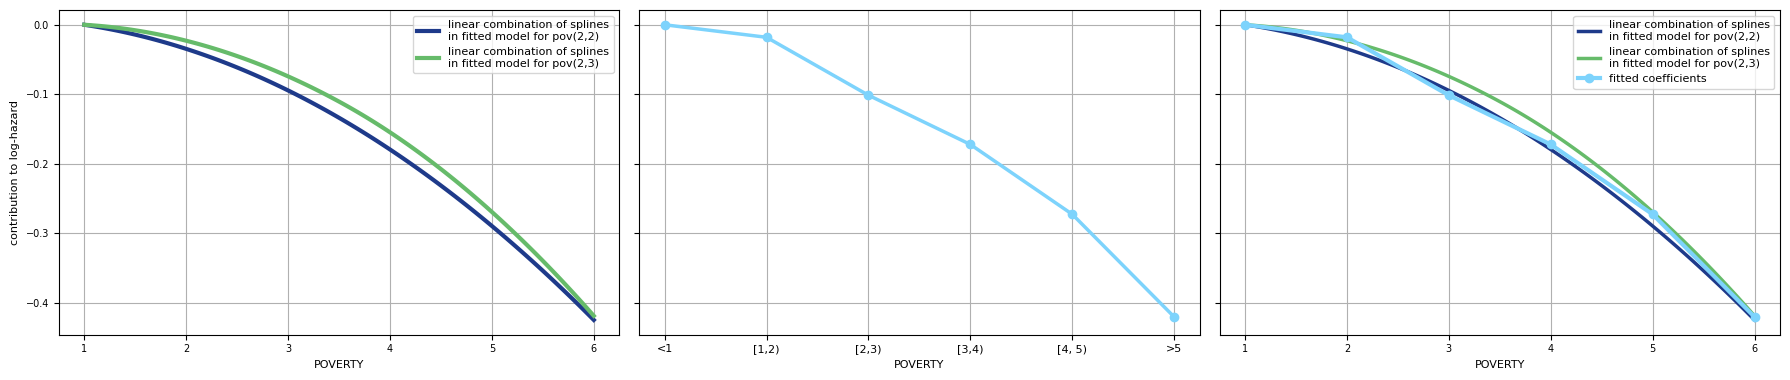

In [50]:
# ---create figure---
fig, axes = plt.subplots(1, 3, figsize=(18, 3.9), sharey=True) 

# ---first plot--- 
axes[0].plot(pov_values, log_hazard_22, label="linear combination of splines\nin fitted model for pov(2,2)", color='#1E3A8A', linewidth=3)
axes[0].plot(pov_values, log_hazard_23, label="linear combination of splines\nin fitted model for pov(2,3)", color='#66BB6A', linewidth=3)
axes[0].set_xlabel("POVERTY", fontsize=8)
axes[0].set_ylabel("Contribution to Log Hazard", fontsize=8)
axes[0].legend(fontsize=8)
axes[0].grid(True)
axes[0].tick_params(axis='both', labelsize=7)
axes[0].set_ylabel("contribution to log-hazard", fontsize=8)

# ---second plot--- 
ticks = {0: '<1',1: '[1,2)', 2: '[2,3)',3:'[3,4)', 4: '[4, 5)', 5 :'>5' }
axes[1].plot(range(len(coeffs_dummy)), coeffs_dummy, marker='o', color='#7DD3FC', linewidth=2.5)
axes[1].set_xlabel("POVERTY", fontsize=8)
axes[1].set_xticks(range(len(ticks)))
axes[1].set_xticklabels(ticks, fontsize=8)
axes[1].grid(True)
axes[1].set_xticks(list(ticks.keys()))
axes[1].set_xticklabels(list(ticks.values()), fontsize=8)

# ---combined plot--- 
axes[2].plot(pov_values, log_hazard_22, label="linear combination of splines\nin fitted model for pov(2,2)", color='#1E3A8A', linestyle='-', linewidth=2.5)
axes[2].plot(pov_values, log_hazard_23, label="linear combination of splines\nin fitted model for pov(2,3)", color='#66BB6A', linestyle='-', linewidth=2.5)
axes[2].plot(range(1,len(coeffs_dummy)+1), coeffs_dummy, marker='o', color='#7DD3FC', label="fitted coefficients", linewidth=3)
axes[2].set_xlabel("POVERTY", fontsize=8)
axes[2].legend(fontsize=8)
axes[2].grid(True)
axes[2].tick_params(axis='both', labelsize=7)

plt.tight_layout()
plt.savefig("POVERTY_combined_all.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

In [51]:
# WRYRET

In [52]:
# WRYMEDCST

In [53]:
# AWORTHLESS

In [54]:
# AEFFORT

In [55]:
# AFEELINT1MO

In [56]:
# ---CPH2 final---

In [57]:
formula="bs(BMICALC, degree=2, df=3) + bs(HRSLEEP, degree=1, df=2) + bs(STRONGFWK, degree=2, df=2) + bs(ALCDAYSYR, degree=1, df=2) + bs(ALCAMT, degree=2, df=2) + bs(POVERTY, degree=2, df=2) +" + " + ".join(df_train_cph2.columns.difference(['TIMETOEVENT', 'MORTSTAT','BMICALC', 'HRSLEEP', 'STRONGFWK', 'ALCDAYSYR', 'ALCAMT','POVERTY']))

cph = CoxPHFitter()
cph.fit(df_train_cph2, duration_col='TIMETOEVENT', event_col='MORTSTAT', formula=formula)

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 82720 total observations, 78101 right-censored observations>
             duration col = 'TIMETOEVENT'
                event col = 'MORTSTAT'
      baseline estimation = breslow
   number of observations = 82720
number of events observed = 4619
   partial log-likelihood = -45546.48
         time fit was run = 2025-03-10 00:15:57 UTC

---
                                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                         
bs(BMICALC, degree=2, df=3)[1]   -1.13      0.32      0.14           -1.40           -0.85                0.25                0.43
bs(BMICALC, degree=2, df=3)[2]   -1.35      0.26      0.11           -1.56           -1.14                0.21                0.32
bs(BMICALC, degree=2, df=3)[3]   -0.69      0.50      0.21           -1.11           -0.27                0.33                0.76
bs(HRSLEEP, degree=1, df=2)[1]   -0.31      0.73      0.10           -0.50           -0.12                0.61                0.89
bs(HRSLEEP, degree=1, df=2)[2]    0.69      2.00      0.11            0.49            0.90                1.63                2.46
bs(STRONGFWK, degree=2, df=2)[1] -0.27      0.76      0.14           -0.55            0.01                0.58                1.01
bs(STRONGFWK, degree=2, df=2)[2]  0.05      1.05      0.10           -0.14            0.25                0.87                1.29
bs(ALCDAYSYR, degree=1, df=2)[1] -0.23      0.80      0.08           -0.38           -0.08                0.69                0.92
bs(ALCDAYSYR, degree=1, df=2)[2] -0.34      0.71      0.08           -0.50           -0.18                0.60                0.84
bs(ALCAMT, degree=2, df=2)[1]     0.62      1.86      0.21            0.20            1.04                1.23                2.83
bs(ALCAMT, degree=2, df=2)[2]     0.24      1.27      0.15           -0.04            0.52                0.96                1.69
bs(POVERTY, degree=2, df=2)[1]   -0.06      0.95      0.09           -0.23            0.12                0.79                1.13
bs(POVERTY, degree=2, df=2)[2]   -0.42      0.65      0.06           -0.54           -0.31                0.58                0.73
AEFFORT                           0.07      1.08      0.02            0.03            0.11                1.04                1.12
AFEELINT1MO                      -0.05      0.95      0.02           -0.08           -0.01                0.92                0.99
AGE                               0.07      1.07      0.00            0.07            0.07                1.07                1.08
ALC5UPYR                          0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ALCSTAT1_2                        0.02      1.02      0.04           -0.06            0.11                0.94                1.11
ALCSTAT1_3                       -0.19      0.83      0.09           -0.36           -0.01                0.70                0.99
ARTHGLUPEV                       -0.03      0.97      0.03           -0.09            0.04                0.91                1.04
AWORTHLESS                        0.01      1.01      0.02           -0.04            0.05                0.96                1.05
BLIND                             0.58      1.78      0.11            0.37            0.79                1.44                2.20
CANCEREV                          0.30      1.35      0.03            0.23            0.37                1.26                1.44
CHEARTDIEV                        0.17      1.19      0.04            0.09            0.26                1.09                1.30
CIGSDAY                           0.00      1.00      0.01           -0.01            0.01                0.99                1.01
CPOXEV                           -0.09      0.91      0.04           -0.17           -0

In [58]:
print(f'APLL_is: {cph.score(df_train_cph2, scoring_method="log_likelihood"):.4f}')
print(f'APLL_os: {cph.score(df_test_cph2, scoring_method="log_likelihood"):.4f}')
print(f'APLL_is: {cph.score(df_train_cph2, scoring_method="concordance_index"):.4f}')
print(f'APLL_os: {cph.score(df_test_cph2, scoring_method="concordance_index"):.4f}')

APLL_is: -0.5506
APLL_os: -0.4609
APLL_is: 0.8852
APLL_os: 0.8891


In [59]:
# predict the survival function for each individual
survival_probs_16_train = cph.predict_survival_function(df_train_cph2)
survival_probs_16_test = cph.predict_survival_function(df_test_cph2)

# extract 3y survival probabilities
survival_prob_3y_train = survival_probs_16_train.iloc[3] 
survival_prob_3y_test = survival_probs_16_test.iloc[3] 

# get 3-year event status based on TIMETOEVENT and MORTSTAT
status_3y_train = np.where((df_train_cph2["MORTSTAT"] == 1) & (df_train_cph2["TIMETOEVENT"] <= 3), 0, 1)
status_3y_test = np.where((df_test_cph2["MORTSTAT"] == 1) & (df_test_cph2["TIMETOEVENT"] <= 3), 0, 1)

print(f'log-loss is: {log_loss(status_3y_train, survival_prob_3y_train):.4f}')
print(f'log-loss os: {log_loss(status_3y_test, survival_prob_3y_test):.4f}')
print(f'BS is: {brier_score_loss(status_3y_train, survival_prob_3y_train):.4f}')
print(f'BS os: {brier_score_loss(status_3y_test, survival_prob_3y_test):.4f}')

log-loss is: 0.1123
log-loss os: 0.1102
BS is: 0.0295
BS os: 0.0293


In [60]:
# save for next model
df_train_cph2.to_csv("df_train_cph2.csv", index=False)
df_test_cph2.to_csv("df_test_cph2.csv", index=False)